# HW 2 - Разложение матриц градиентным методом

Цель задания: В ходе реализации [разложения Таккера](https://proceedings.neurips.cc/paper/2018/file/45a766fa266ea2ebeb6680fa139d2a3d-Paper.pdf) градиентным методом освоить pyTorch и реализовать подходы оптимизации параметров модели (в отсутствии готовых решений).

[Более-менее внятное описание алгоритма канонического разложения](https://www.alexejgossmann.com/tensor_decomposition_tucker/)

In [44]:
import random
import time
import torch
import pandas as pd
import numpy as np
import tensorly
import statistics


import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from numpy.linalg import svd, matrix_rank, pinv, inv
from scipy.linalg import eigh, eig
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm
from torch import nn

from tensorly import decomposition
from torch.nn.functional import mse_loss
from torch.optim import Adam, SGD
torch.manual_seed(0)

## 1 Создайте 3х мерный тензор
Размер тензора не меньше 100 по каждой из размерностей.

Заполните случайными целыми числами в диапазоне от 0 до 9.

Примечание: разложение будет корректно работать со случайным тензором, только если изначально создавать случайные ядро и матрицы, а потом по ним формировать тензор. Работайте с типом *torch.Tensor.double*.

In [5]:
# Создадим тензор: размер тензора и r задаётся
def get_tensor_tenalg(size=(100,200,150), r=10):
    # data - тензор с заданной размерностью
    # U - список матриц
    # G - ядро разложения
    U = [np.random.randint(0,10, (i, r)) for i in size]
    G = np.random.randint(0,9,(r,r,r))
    data = torch.tensor(tensorly.tenalg.multi_mode_dot(G, U)) #multi_mode_dot work with np
    return data, U, torch.tensor(G)

Сгенерируйте тензор и добавьте к нему случайный шум с размерностью *1e-2*

In [6]:
data, U, G = get_tensor_tenalg(size=(100, 200, 300))
data.shape, [u.shape for u in U], G.shape

(torch.Size([100, 200, 300]),
 [(100, 10), (200, 10), (300, 10)],
 torch.Size([10, 10, 10]))

In [7]:
noise = torch.rand(data.shape)/10
data_noise = data.add(noise)
data, data_noise
mse_loss(data, data_noise)

tensor(0.0034)

### my realisation

In [8]:
def unfold(tensor, mode):
    return torch.reshape(torch.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1))

def fold(tensor, mode, shape):
    full_shape = list(shape)
    mode_shape = full_shape.pop(mode)
    full_shape.insert(0, mode_shape)
    return torch.moveaxis(torch.reshape(tensor, full_shape), 0, mode)

In [9]:
def my_composition(G_, U):
    data = G_.clone()
    for i in range(len(U)):
        init_shape = list(data.shape)
        new_shape = init_shape.copy()
        new_shape[i] = U[i].shape[0]
        G_i = unfold(data,i)
        data = fold((U[i]@G_i), i, new_shape);
    return data

In [10]:
def get_tensor_my(size=(100,200,150), r=10):
    #U = [np.random.randint(0,10, (i, r)).astype(float) for i in size]
    #G = np.random.randint(0,9,(r,r,r)).astype(float)
    #U_tl = [torch.tensor(u) for u in U ]
    #G_tl = torch.tensor(G)
    U = [torch.randint(0,10,(s, r)).float() for s in size]
    G = torch.randint(0,10,(r, r, r)).float()
    data = my_composition(G, U)
    return data, U, G

In [11]:
data_m, U_m, G_m = get_tensor_my(size=(100, 200, 150),r = 10) #size(depth,rows,columns) 

In [12]:
noise_m = torch.rand(data_m.shape)/10
data_noise_m = data_m.add(noise_m)
data_m, data_noise_m
mse_loss(data_m, data_noise_m)

tensor(0.0034)

Вопрос:
Почему задание не имеет смысла для полностью случайного тензора и зачем добавлять шум? *не отвечать нельзя*

Ответ:

## 3 Сделайте разложение библиотечным методом
Пакет можете брать любой

In [13]:
G_d, U_d = tensorly.decomposition.tucker(tensorly.tensor(data_noise_m), G_m.shape)
G_d.shape, U_d[1].shape

((10, 10, 10), (200, 10))

In [14]:
data_d = torch.tensor(tensorly.tenalg.multi_mode_dot(G_d, U_d))

Не забудьте померить ошибку разложения по метрике MSE

In [15]:
mse_loss(data_noise_m, data_d)

tensor(0.0010, dtype=torch.float64)

# Better make it on google-collab 

### 4.1 Реализуйте *optimizer*
Можно взять из исходников *PyTorch* и отнаследоваться от *torch.optim.optimizer*.
Используйте квадратичный *Loss*.

In [91]:
import math
import torch
from torch.optim.optimizer import Optimizer
from torch.optim.lr_scheduler import CyclicLR

class Opt(Optimizer):

    def __init__(self, data, G, U, batch_size, lr=4e-4):
        self.data = data 
        self.batch_size = batch_size
        params = [G, *U]
        defaults = {"lr": lr}
        super().__init__(params, defaults)
        self.grad_max = np.array([])
    
    def step(self):
        grad = None
        while grad is None:
            maxim = -1
            for i in range(len(self.param_groups[0]['params'])):
                if self.param_groups[0]['params'][i].grad.data.max() > maxim:
                    maxim = self.param_groups[0]['params'][i].grad.data.max()
                    tensor = self.param_groups[0]['params'][i]
                    grad = tensor.grad
                
#             l = len(self.param_groups[0]['params'])
#             tensor = self.param_groups[0]['params'][np.random.randint(l)]
#             grad = tensor.grad
            

        if not self.state:
            self.state["step"] = 1
        else:
            self.state["step"] += 1
            
        #if self.state["step"] % 100 == 0:
        #    self.param_groups[0]['lr'] /= 2
            
        if self.state["step"] % 1000 == 0:
            self.param_groups[0]['lr'] /= 10 
        #print(grad.data.max())  
        self.grad_max = np.append(self.grad_max, grad.data.max())
        elems = random.sample(range(1, tensor.numel()), self.batch_size)

        mask_flat = torch.zeros(tensor.numel())
        mask_flat[elems] = 1
        mask = mask_flat.reshape(tensor.shape)
        
        tensor.data.add_(grad * mask, alpha=-self.param_groups[0]['lr'])

### 4.2 Реализуйте цикл оптимизации параметров

Стоит параметры оптимизировать сразу на GPU

In [95]:
def optimization(G, U, data, opt, it, err, loss_history):
    optim_f = opt
    #optim_f = torch.optim.lr_scheduler.CyclicLR(optim_f, base_lr=10**-10, max_lr=10**-7,cycle_momentum=False)
    flag = True
    start_time = time.time()
    for i in range(it):
        
        optim_f.zero_grad()
        loss = mse_loss(my_composition(G,U), data)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(opt.param_groups[0]['params'], 10**10) #10**20
        optim_f.step()
        #print(loss.data)
        if i%400 == 0:
            print(f'itr {i} mse is {loss.data} time of work: {time.time()-start_time} optimizer: {type(optim_f)}')
            #print(f'itr {i} mse is {loss.data}')
        if loss.data < err:
            print(time.time()-start_time)
            break 

        if i > 1000 and (flag and 0.9*statistics.mean(loss_history[i-400:i]) - int(loss.data) < 0):
            flag = False
            optim_f = Adam([G, *U])
            #optim_f = torch.optim.lr_scheduler.CyclicLR(optim_f, base_lr=10**-10, max_lr=10**-7, cycle_momentum=False)
            print('change optim', type(optim_f))
#         if i == 4000:
#             optim_f = SGD([G_opt, *U_opt], lr=10**-8)
#             print('change optim')
        loss_history.append(int(loss.data))
    return 

- Определить max learning rate при котром начинается обучение 
- Реализовать learnin
- визуализировать градиенты .grad.data.max
- добавить клиппинг

## 5 Приведите сравнение скорости работы и ошибки восстановления методом из пакета и реализованного градиентного
Сравнение может считаться ± объективным с размером выборки от 10.

In [96]:
size = (100,200,150)
r = 10
itr = 70000
lr = 10**-7
eps = 0.004
batch_size = 700

data, U, G = get_tensor_my(size, r)
noise = torch.rand(data.shape) / 10
data = noise.add(data)

G_opt = torch.randint(0, 10, (r, r, r)).float().requires_grad_()
U_opt = [torch.randint(0, 10, (s, r)).float().requires_grad_() for s in size]

loss_history = []
my_optimizer = Opt(data, G_opt, U_opt, batch_size, lr)
#my_optimizer = Adam([G_opt, *U_opt])
#my_optimizer = SGD([G_opt, *U_opt], lr=10**-8)

In [ ]:
start_time = time.time()

optimization(G_opt, U_opt, data, my_optimizer, itr, eps, loss_history)

whole_time = time.time()-start_time  #total 40 minuts

itr 0 mse is 42729549824.0 time of work: 0.04938387870788574 optimizer: <class '__main__.Opt'>
itr 400 mse is 42476216.0 time of work: 16.665729522705078 optimizer: <class '__main__.Opt'>


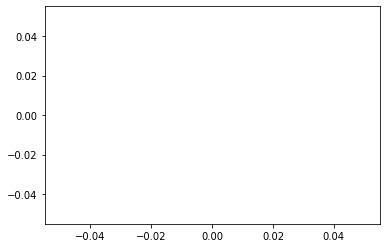

In [90]:
len(my_optimizer.grad_max)
plt.scatter(np.arange(0,len(my_optimizer.grad_max[800:])), my_optimizer.grad_max[800:])

In [58]:
len(loss_history)

70000

In [76]:
loss_np = np.array(loss_history)

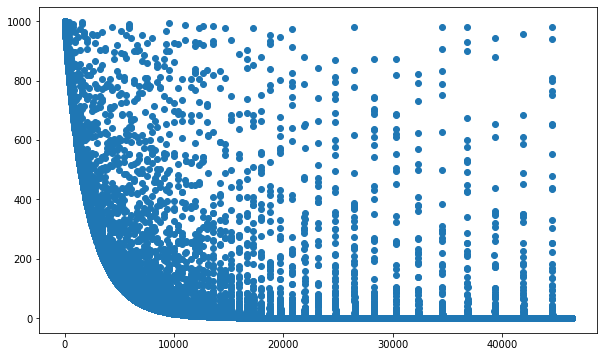

In [82]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.scatter(np.arange(0, len(loss_np[loss_np < 1000])), loss_np[loss_np < 1000])
plt.show()

In [83]:
start_time = time.time()
#data_d = torch.tensor(tensorly.tenalg.multi_mode_dot(G_opt, U_opt))

whole_time = time.time()-start_time

TypeError: ignored

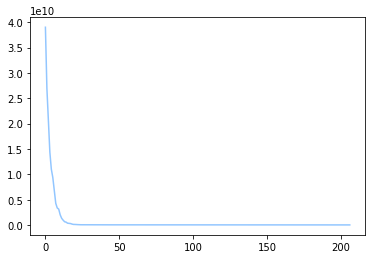

In [107]:
# #importing libraries
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# %matplotlib inline
# x = np.arange(0,len(loss_history))
# y = loss_history 

# plt.ion()

# fig, ax = plt.subplots()
# line, = ax.plot(x, y)


# for i in range(0, len(loss_history)):
#   line.set_ydata(y)
#   plt.draw()
#   #plt.show()
#   plt.gcf().canvas.flush_events()
  
#   time.sleep(0.02)



# plt.ioff()
# plt.show()

In [114]:
#loss_history 

In [ ]:
#from tensorly import fold, unfold
# def mode_dot(tensor, matrix, mode):
#     new_shape = list(tensor.shape) 
#     new_shape[mode] = matrix.shape[0]
#     #print(unfold(tensor, mode), 'unfold')
#     res = torch.tensordot(matrix, unfold(tensor, mode))
#     return fold(res, mode, new_shape)

# def multi_mode_dot(tensor, matrix):
#     modes = range(len(matrix))
#     res = tensor
#     for (mode, matrix) in enumerate(matrix):
#         res = mode_dot(res, matrix, mode)
#         #print(res,'fold')
#     return torch.tensor(res)

In [ ]:
# def get_tensor_my_GU(G, U):
#     #prediction = policy_model(torch.from_numpy(G))
#     #motor_controls = prediction.clone().detach().numpy()
    
#     U_np = [u.clone().detach().numpy() for u in U]
#     data = torch.tensor(multi_mode_dot(G.clone().detach().numpy(), U_np))
#     return data